# Predicting the Residuary Resistance of Sailing Yachts

1. **Frame the problem and look at the big picture**
2. **Get the Data**
3. **Data Insights**
4. **Prepare the Data for ML Algorithms**
5. **Select and Train a Model**
6. **Model Fine-Tuning**
7. **Test Set Evaluation**
8. **Deploy the Model**

In [1]:
import sys
print("Python version:", sys.version_info)

Python version: sys.version_info(major=3, minor=8, micro=13, releaselevel='final', serial=0)


In [2]:
import sklearn
print("scikit-learn version:", sklearn.__version__)

scikit-learn version: 1.0.2


# 2. Get the Data

In [3]:
import os
import urllib.request

In [4]:
DOWNLOAD_ROOT = "http://archive.ics.uci.edu/ml/machine-learning-databases/00243/"
DATA_URL = DOWNLOAD_ROOT + "yacht_hydrodynamics.data"
DATA_PATH = os.path.join("datasets", "yacht")

In [5]:
def fetch_data(data_url=DATA_URL, data_path=DATA_PATH):
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    full_data_path = os.path.join(data_path, "yacht_hydrodynamics.data")
    urllib.request.urlretrieve(data_url, full_data_path)

fetch_data()

In [6]:
import pandas as pd

columns = ["Centre_of_Buoyancy", "Prismatic_Coefficient", "Length/Displacement_Ratio", "Beam/Draft_Ratio", 
           "Length/Beam_Ratio", "Froude_Number", "Residuary_Resistance"]

def load_data(data_path=DATA_PATH):
    full_data_path = os.path.join(data_path, "yacht_hydrodynamics.data")
    return pd.read_table(full_data_path, sep='\s+', names=columns)

yacht = load_data()

# 3. Data Insights

This is an iterative process: once you get a prototype up and running, you can analyze its output to gain more insights and come back to this
exploration step.

1. Check for data type of columns
2. Check for null values
3. Check for statistics
3. Plot for correlations
4. Create a test set
5. Look for new attributes

## The Data Structure

In [7]:
# look at the top ten rows
yacht.head(10)

,Centre_of_Buoyancy,Prismatic_Coefficient,Length/Displacement_Ratio,Beam/Draft_Ratio,Length/Beam_Ratio,Froude_Number,Residuary_Resistance
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
5,-2.3,0.568,4.78,3.99,3.17,0.250,1.82
6,-2.3,0.568,4.78,3.99,3.17,0.275,2.61
7,-2.3,0.568,4.78,3.99,3.17,0.300,3.76
8,-2.3,0.568,4.78,3.99,3.17,0.325,4.99
9,-2.3,0.568,4.78,3.99,3.17,0.350,7.16


In [8]:
# get a quick description of the data:
# the total number of rows, each attribute's type, and the number of non-null values
yacht.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Centre_of_Buoyancy         308 non-null    float64
 1   Prismatic_Coefficient      308 non-null    float64
 2   Length/Displacement_Ratio  308 non-null    float64
 3   Beam/Draft_Ratio           308 non-null    float64
 4   Length/Beam_Ratio          308 non-null    float64
 5   Froude_Number              308 non-null    float64
 6   Residuary_Resistance       308 non-null    float64
dtypes: float64(7)
memory usage: 17.0 KB


There are 308 instances in the dataset, which means that it is fairly small by ML standards, but the aim of this project is to apply machine learning in the domain of naval engineering.

In [9]:
# the number of null values for each attribute
yacht.isnull().sum()

Centre_of_Buoyancy           0
Prismatic_Coefficient        0
Length/Displacement_Ratio    0
Beam/Draft_Ratio             0
Length/Beam_Ratio            0
Froude_Number                0
Residuary_Resistance         0
dtype: int64

In [10]:
# 22 sailing yacht hull forms were tested at the same speeds within the speed range 0.125 - 0.450
yacht["Froude_Number"].value_counts()

0.125    22
0.150    22
0.175    22
0.200    22
0.225    22
0.250    22
0.275    22
0.300    22
0.325    22
0.350    22
0.375    22
0.400    22
0.425    22
0.450    22
Name: Froude_Number, dtype: int64

In [11]:
# get a summary of the numerical attributes
yacht.describe().round(3)

,Centre_of_Buoyancy,Prismatic_Coefficient,Length/Displacement_Ratio,Beam/Draft_Ratio,Length/Beam_Ratio,Froude_Number,Residuary_Resistance
count,308.000,308.000,308.000,308.000,308.000,308.000,308.000
mean,-2.382,0.564,4.789,3.937,3.207,0.288,10.495
std,1.513,0.023,0.253,0.548,0.248,0.101,15.160
min,-5.000,0.530,4.340,2.810,2.730,0.125,0.010
25%,-2.400,0.546,4.770,3.750,3.150,0.200,0.778
50%,-2.300,0.565,4.780,3.955,3.150,0.288,3.065
75%,-2.300,0.574,5.100,4.170,3.510,0.375,12.815
max,0.000,0.600,5.140,5.350,3.640,0.450,62.420


The std row shows the standard deviation, which measures how dispersed the values are.

The 25%, 50% and 75% rows show the corresponding percentiles, which indicate the values below which a given percentage of observations in a group of observations fall. 

For example, 50% of the hull forms have the residuary resistance lower than 3.065, while the max value is 62.42.

array([[<AxesSubplot:title={'center':'Centre_of_Buoyancy'}>,
        <AxesSubplot:title={'center':'Prismatic_Coefficient'}>,
        <AxesSubplot:title={'center':'Length/Displacement_Ratio'}>],
       [<AxesSubplot:title={'center':'Beam/Draft_Ratio'}>,
        <AxesSubplot:title={'center':'Length/Beam_Ratio'}>,
        <AxesSubplot:title={'center':'Froude_Number'}>],
       [<AxesSubplot:title={'center':'Residuary_Resistance'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

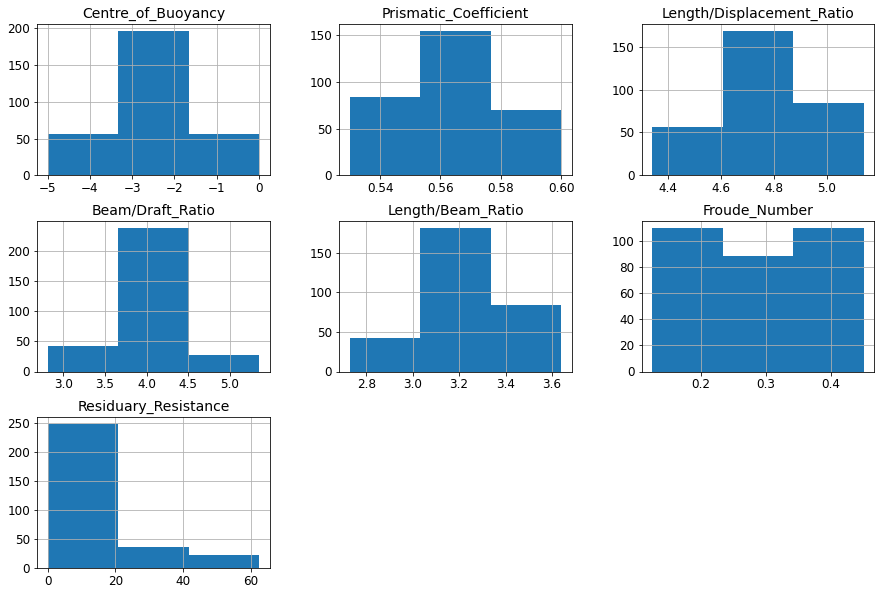

In [12]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc("font", size=14)
mpl.rc("axes", labelsize=14, titlesize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# for each attribute, show the number of instances (on the vertical axis) that have a given value range (on the horizontal axis)
yacht.hist(bins=3, figsize=(15, 10))

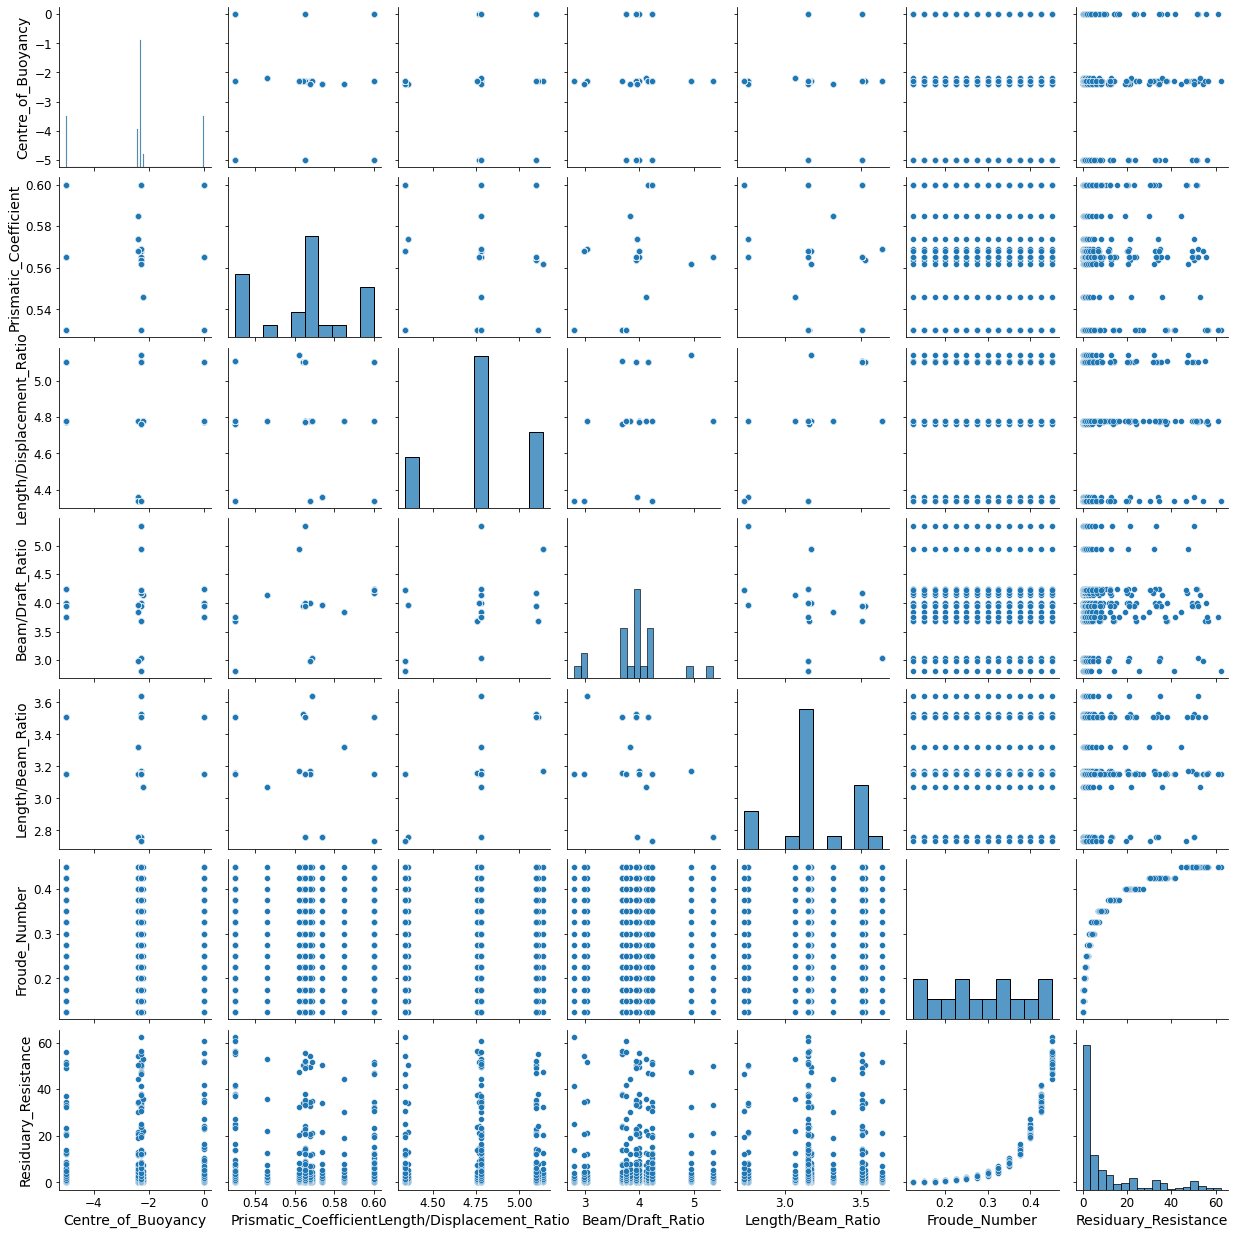

In [13]:
import seaborn as sns

# get an intuition of potential correlations
sns.pairplot(yacht)

<AxesSubplot:xlabel='Froude_Number', ylabel='Residuary_Resistance'>

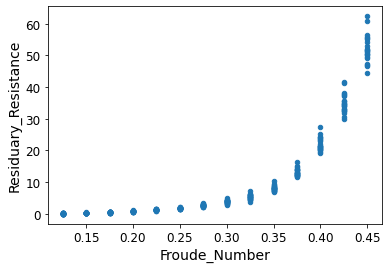

In [14]:
yacht.plot(kind="scatter", x="Froude_Number", y="Residuary_Resistance")

**The residuary resistance grows eponentially with increase of the velocity.**

## Create a Test Set

Create homogeneous subgroups called strata from the overall population and sample the right number of instances to each stratum to ensure that the test set is representative of the overall population.

In [15]:
yacht["Length/Displacement_Ratio"].value_counts() / len(yacht)

4.78    0.409091
5.10    0.181818
4.34    0.136364
4.77    0.090909
4.36    0.045455
5.14    0.045455
5.11    0.045455
4.76    0.045455
Name: Length/Displacement_Ratio, dtype: float64

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

# stratified sampling based on the length/displacement ratio
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(yacht, yacht["Length/Displacement_Ratio"]):
    strat_train_set = yacht.loc[train_index]
    strat_test_set = yacht.loc[test_index]

In [17]:
# check for the distribution in the training set
strat_train_set["Length/Displacement_Ratio"].value_counts() / len(strat_train_set)

4.78    0.410569
5.10    0.182927
4.34    0.138211
4.77    0.089431
5.14    0.044715
4.36    0.044715
5.11    0.044715
4.76    0.044715
Name: Length/Displacement_Ratio, dtype: float64

In [18]:
# check for the distribution in the test set
strat_test_set["Length/Displacement_Ratio"].value_counts() / len(strat_test_set)

4.78    0.403226
5.10    0.177419
4.34    0.129032
4.77    0.096774
4.76    0.048387
5.14    0.048387
5.11    0.048387
4.36    0.048387
Name: Length/Displacement_Ratio, dtype: float64

## Data Correlations

In [19]:
yacht = strat_train_set.copy()

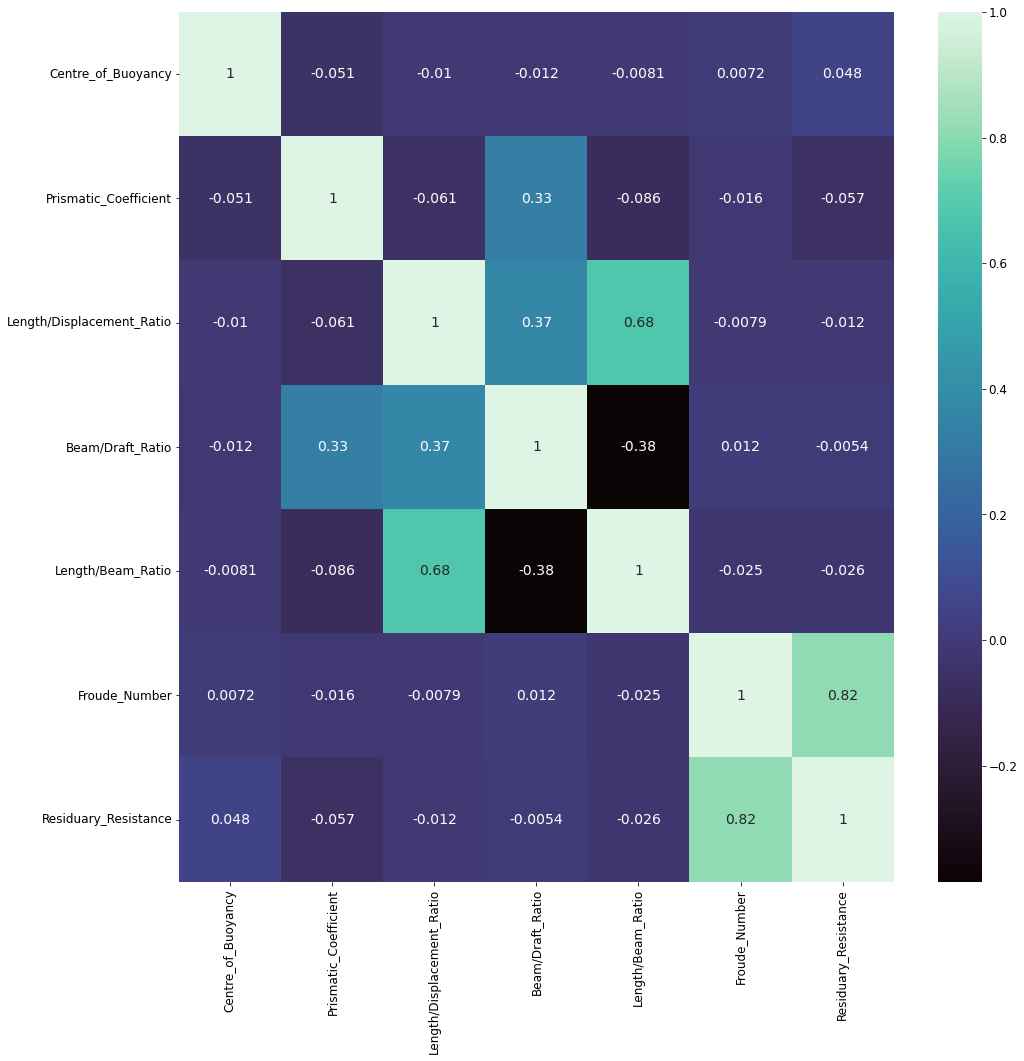

In [20]:
# get correlations of each features in the dataset
corrmat = yacht.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(16, 16))

# plot heat map
g=sns.heatmap(yacht[top_corr_features].corr(), annot=True, cmap="mako")

In [21]:
corr_matrix = yacht.corr()

corr_matrix["Residuary_Resistance"].sort_values(ascending=False)

Residuary_Resistance         1.000000
Froude_Number                0.815643
Centre_of_Buoyancy           0.048240
Beam/Draft_Ratio            -0.005433
Length/Displacement_Ratio   -0.011558
Length/Beam_Ratio           -0.026334
Prismatic_Coefficient       -0.056833
Name: Residuary_Resistance, dtype: float64

## Test New Attributes

1. Centre_of_Buoyancy/Froude_Number
2. Prismatic_Coefficient/Froude_Number
3. Length_Displacement_Ratio/Froude_Number
4. Length_Beam_Ratio/Froude_Number
5. Beam_Draft_Ratio/Froude_Number

In [22]:
yacht["Centre_of_Buoyancy/Froude_Number"] = yacht["Centre_of_Buoyancy"] / yacht["Froude_Number"]
yacht["Prismatic_Coefficient/Froude_Number"] = yacht["Prismatic_Coefficient"] / yacht["Froude_Number"]
yacht["Length_Displacement_Ratio/Froude_Number"] = yacht["Length/Displacement_Ratio"] / yacht["Froude_Number"]
yacht["Length_Beam_Ratio/Froude_Number"] = yacht["Length/Beam_Ratio"] / yacht["Froude_Number"]
yacht["Beam_Draft_Ratio/Froude_Number"] = yacht["Beam/Draft_Ratio"] / yacht["Froude_Number"]

In [23]:
yacht.head()

,Centre_of_Buoyancy,Prismatic_Coefficient,Length/Displacement_Ratio,Beam/Draft_Ratio,Length/Beam_Ratio,Froude_Number,Residuary_Resistance,Centre_of_Buoyancy/Froude_Number,Prismatic_Coefficient/Froude_Number,Length_Displacement_Ratio/Froude_Number,Length_Beam_Ratio/Froude_Number,Beam_Draft_Ratio/Froude_Number
8,-2.3,0.568,4.78,3.99,3.17,0.325,4.99,-7.076923,1.747692,14.707692,9.753846,12.276923
9,-2.3,0.568,4.78,3.99,3.17,0.350,7.16,-6.571429,1.622857,13.657143,9.057143,11.400000
96,-2.3,0.562,5.14,4.95,3.17,0.425,32.34,-5.411765,1.322353,12.094118,7.458824,11.647059
39,-2.3,0.565,4.78,5.35,2.76,0.400,21.40,-5.750000,1.412500,11.950000,6.900000,13.375000
262,0.0,0.530,4.78,3.75,3.15,0.375,16.31,0.000000,1.413333,12.746667,8.400000,10.000000


In [24]:
import numpy as np

np.isinf(yacht).values.sum()

0

In [25]:
corr_matrix = yacht.corr()

corr_matrix["Residuary_Resistance"].sort_values(ascending=False)

Residuary_Resistance                       1.000000
Froude_Number                              0.815643
Centre_of_Buoyancy/Froude_Number           0.354648
Centre_of_Buoyancy                         0.048240
Beam/Draft_Ratio                          -0.005433
Length/Displacement_Ratio                 -0.011558
Length/Beam_Ratio                         -0.026334
Prismatic_Coefficient                     -0.056833
Beam_Draft_Ratio/Froude_Number            -0.584934
Length_Beam_Ratio/Froude_Number           -0.609268
Length_Displacement_Ratio/Froude_Number   -0.613812
Prismatic_Coefficient/Froude_Number       -0.622585
Name: Residuary_Resistance, dtype: float64

# 4. Prepare the Data for ML Algorithms

1. Clean the data
2. Add new attributes
3. Scale the data
3. Set up a transformation pipeline

In [26]:
yacht = strat_train_set.drop("Residuary_Resistance", axis=1)
yacht_labels = strat_train_set["Residuary_Resistance"].copy()

## Data Cleaning

In [27]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
imputer.fit(yacht)

SimpleImputer(strategy='median')

In [28]:
# median of each column
imputer.statistics_

array([-2.3  ,  0.565,  4.78 ,  3.955,  3.15 ,  0.3  ])

In [29]:
yacht.median().values

array([-2.3  ,  0.565,  4.78 ,  3.955,  3.15 ,  0.3  ])

In [30]:
# impute the missing values with the medians
imputer.transform(yacht)

array([[-2.3  ,  0.568,  4.78 ,  3.99 ,  3.17 ,  0.325],
       [-2.3  ,  0.568,  4.78 ,  3.99 ,  3.17 ,  0.35 ],
       [-2.3  ,  0.562,  5.14 ,  4.95 ,  3.17 ,  0.425],
       ...,
       [-2.3  ,  0.53 ,  5.11 ,  3.69 ,  3.51 ,  0.275],
       [ 0.   ,  0.6  ,  4.78 ,  4.24 ,  3.15 ,  0.3  ],
       [-2.3  ,  0.564,  5.1  ,  3.95 ,  3.53 ,  0.425]])

## Attribute Addition

In [31]:
# get the column indices
Centre_of_Buoyancy_ix, Prismatic_Coefficient_ix, Length_Displacement_Ratio_ix, Beam_Draft_Ratio_ix, Length_Beam_Ratio_ix, Froude_Number_ix = [yacht.columns.get_loc(c) for c in yacht.columns]
Centre_of_Buoyancy_ix, Prismatic_Coefficient_ix, Length_Displacement_Ratio_ix, Beam_Draft_Ratio_ix, Length_Beam_Ratio_ix, Froude_Number_ix

(0, 1, 2, 3, 4, 5)

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class AttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_Dim_Fn_ratio=False):
        self.add_Dim_Fn_ratio = add_Dim_Fn_ratio
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Lbc_Fn_ratio = X[:, Centre_of_Buoyancy_ix] / X[:, Froude_Number_ix] 
        Cp_Fn_ratio = X[:, Prismatic_Coefficient_ix] / X[:, Froude_Number_ix] 
        if self.add_Dim_Fn_ratio:
            LD_Fn_ratio = X[:, Length_Displacement_Ratio_ix] / X[:, Froude_Number_ix]
            LB_Fn_ratio = X[:, Length_Beam_Ratio_ix] / X[:, Froude_Number_ix]
            BT_Fn_ratio = X[:, Beam_Draft_Ratio_ix] / X[:, Froude_Number_ix]
            return np.c_[X, Lbc_Fn_ratio, Cp_Fn_ratio, LD_Fn_ratio, LB_Fn_ratio, BT_Fn_ratio]
        else:
            return np.c_[X, Lbc_Fn_ratio, Cp_Fn_ratio]

In [33]:
yacht.columns

Index(['Centre_of_Buoyancy', 'Prismatic_Coefficient',
       'Length/Displacement_Ratio', 'Beam/Draft_Ratio', 'Length/Beam_Ratio',
       'Froude_Number'],
      dtype='object')

In [34]:
list(yacht.columns)

['Centre_of_Buoyancy',
 'Prismatic_Coefficient',
 'Length/Displacement_Ratio',
 'Beam/Draft_Ratio',
 'Length/Beam_Ratio',
 'Froude_Number']

In [35]:
attribute_adder = AttributeAdder(add_Dim_Fn_ratio=False)
yacht_extra_attr = attribute_adder.transform(yacht.values)

# if add_Dim_Fn_ratio = False
col1 = ["Centre_of_Buoyancy/Froude_Number", "Prismatic_Coefficient/Froude_Number", "Length_Displacement_Ratio/Froude_Number",
        "Length_Beam_Ratio/Froude_Number", "Beam_Draft_Ratio/Froude_Number"] 

# id add_Dim_Fn_ratio = True
col2 = ["Centre_of_Buoyancy/Froude_Number", "Prismatic_Coefficient/Froude_Number"]

yacht_extra_attr = pd.DataFrame(yacht_extra_attr, columns=list(yacht.columns)+col2, index=yacht.index)

yacht_extra_attr.head()

,Centre_of_Buoyancy,Prismatic_Coefficient,Length/Displacement_Ratio,Beam/Draft_Ratio,Length/Beam_Ratio,Froude_Number,Centre_of_Buoyancy/Froude_Number,Prismatic_Coefficient/Froude_Number
8,-2.3,0.568,4.78,3.99,3.17,0.325,-7.076923,1.747692
9,-2.3,0.568,4.78,3.99,3.17,0.350,-6.571429,1.622857
96,-2.3,0.562,5.14,4.95,3.17,0.425,-5.411765,1.322353
39,-2.3,0.565,4.78,5.35,2.76,0.400,-5.750000,1.412500
262,0.0,0.530,4.78,3.75,3.15,0.375,0.000000,1.413333


In [36]:
yacht_extra_attr.describe().round(2)

,Centre_of_Buoyancy,Prismatic_Coefficient,Length/Displacement_Ratio,Beam/Draft_Ratio,Length/Beam_Ratio,Froude_Number,Centre_of_Buoyancy/Froude_Number,Prismatic_Coefficient/Froude_Number
count,246.00,246.00,246.00,246.00,246.00,246.00,246.00,246.00
mean,-2.41,0.57,4.79,3.93,3.21,0.29,-9.71,2.27
std,1.51,0.02,0.25,0.54,0.25,0.10,7.81,0.98
min,-5.00,0.53,4.34,2.81,2.73,0.12,-40.00,1.18
25%,-2.40,0.55,4.77,3.75,3.15,0.20,-13.33,1.50
50%,-2.30,0.56,4.78,3.96,3.15,0.30,-8.00,1.93
75%,-2.30,0.57,5.10,4.17,3.51,0.38,-5.41,2.84
max,0.00,0.60,5.14,5.35,3.64,0.45,0.00,4.80


## Data Scaling

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(yacht_extra_attr)

StandardScaler()

In [38]:
scaler.mean_

array([-2.41219512,  0.56516667,  4.78800813,  3.93069106,  3.21162602,
        0.29004065, -9.71286757,  2.27388254])

In [39]:
scaler.scale_

array([1.50905588, 0.02331946, 0.25299124, 0.54128642, 0.24996869,
       0.10296616, 7.78959106, 0.97900098])

In [40]:
yacht_extra_attr.head(1)

,Centre_of_Buoyancy,Prismatic_Coefficient,Length/Displacement_Ratio,Beam/Draft_Ratio,Length/Beam_Ratio,Froude_Number,Centre_of_Buoyancy/Froude_Number,Prismatic_Coefficient/Froude_Number
8,-2.3,0.568,4.78,3.99,3.17,0.325,-7.076923,1.747692


In [41]:
yacht_extra_attr.head(1).to_numpy()

array([[-2.3       ,  0.568     ,  4.78      ,  3.99      ,  3.17      ,
         0.325     , -7.07692308,  1.74769231]])

In [42]:
scaler.transform(yacht_extra_attr.head(1))

array([[ 0.07434789,  0.12150079, -0.03165378,  0.10957035, -0.16652492,
         0.3395227 ,  0.33839318, -0.53747672]])

In [43]:
(yacht_extra_attr.head(1) - scaler.mean_) / scaler.scale_

,Centre_of_Buoyancy,Prismatic_Coefficient,Length/Displacement_Ratio,Beam/Draft_Ratio,Length/Beam_Ratio,Froude_Number,Centre_of_Buoyancy/Froude_Number,Prismatic_Coefficient/Froude_Number
8,0.074348,0.121501,-0.031654,0.10957,-0.166525,0.339523,0.338393,-0.537477


## Transformation Pipeline

In [44]:
from sklearn.pipeline import Pipeline

# create a transformation pipeline for numerical attributes
yacht_pipeline = Pipeline([
            ("imputer", SimpleImputer(strategy="median")), # impute the missing values
            ("attributes_adder", AttributeAdder()),        # add new attributes
            ("features_scaler", StandardScaler()),         # scale the data
        ])

In [45]:
yacht.head(1)

,Centre_of_Buoyancy,Prismatic_Coefficient,Length/Displacement_Ratio,Beam/Draft_Ratio,Length/Beam_Ratio,Froude_Number
8,-2.3,0.568,4.78,3.99,3.17,0.325


In [46]:
yacht_prepared = yacht_pipeline.fit_transform(yacht)

yacht_prepared[0]

array([ 0.07434789,  0.12150079, -0.03165378,  0.10957035, -0.16652492,
        0.3395227 ,  0.33839318, -0.53747672])

# 5. Select and Train a Model

The following ML models are trained:
1. Linear Regression,
2. Support Vector Machines,
3. Decision Tree,
4. Random Forest.

## Linear Regression

The training process consists of 4 steps:
1. Create an instance of the model class.
2. Train the model using the fit() method.
3. Make predictions by first passing the data through pipeline transformer.
4. Evaluate the model using the Root Mean Squared Error - RMSE (typical performance metric for regression problems).

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [48]:
lin_reg = LinearRegression()
lin_reg.fit(yacht_prepared, yacht_labels)
yacht_predictions = lin_reg.predict(yacht_prepared)

lin_mse = mean_squared_error(yacht_labels, yacht_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse.round(2)

6.18

In [49]:
lin_reg.intercept_, lin_reg.coef_

(11.235284552845549,
 array([ 1.54778266, -1.27024789,  3.0334259 , -2.95052566, -3.35652325,
        31.01994842, -1.20392546, 18.76403509]))

In [50]:
sample_data = yacht_prepared[:5]
sample_labels = yacht_labels.iloc[:5]

print("Sample predictions:", lin_reg.predict(sample_data).round(2))

Sample predictions: [11.38 16.44 32.5  25.6  24.94]


In [51]:
print("Sample labels:", list(sample_labels))

Sample labels: [4.99, 7.16, 32.34, 21.4, 16.31]


This is an example of a model underfitting the training data.

The main ways to fix underfitting are:
1. select a more powerful model,
2. feed the training algorithm with better features,
3. reduce the constraints on the model.

## Support Vector Machines

In [52]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)
svm_reg.fit(yacht_prepared, yacht_labels)

SVR(C=100, coef0=1, gamma='auto', kernel='poly')

In [53]:
svm_yacht_predictions = svm_reg.predict(yacht_prepared)
svm_mse = mean_squared_error(yacht_labels, svm_yacht_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse.round(2)

0.92

In [54]:
print("Sample predictions:", svm_reg.predict(sample_data).round(2))

Sample predictions: [ 4.33  7.84 32.44 22.35 17.39]


In [55]:
print("Sample labels:", list(sample_labels))

Sample labels: [4.99, 7.16, 32.34, 21.4, 16.31]


### Cross-Validation

You need to use part of the training set for training and part of it for model validation.

`cross_val_score` splits the training set into `n` distinct subsets called folds, then trains and evaluates the model `n` times, picking a different fold for evaluation every time and training on the other `n-1` folds.

In [56]:
from sklearn.model_selection import cross_val_score

svm_mse_scores = cross_val_score(svm_reg, yacht_prepared, yacht_labels,
                        scoring="neg_mean_squared_error", cv=10)

svm_rmse_scores = np.sqrt(-svm_mse_scores)

The result is an array containing the `n` evaluation scores.

In [57]:
def display_scores(scores):
    print("Scores:", scores.round(2))
    print("Mean:", scores.mean().round(2))
    print("Standard deviation:", scores.std().round(2))

display_scores(svm_rmse_scores)

Scores: [1.08 2.36 1.29 1.46 1.01 1.21 1.49 1.68 1.49 1.19]
Mean: 1.43
Standard deviation: 0.37


Cross-validation gets not only an estimate of the performance of your model, but also a measure of how precise this estimate is (its standard deviation).

However, cross-validation comes at the cost of training the model several times, what is not always possible.

## Decision Tree

In [58]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(yacht_prepared, yacht_labels)

DecisionTreeRegressor(random_state=42)

In [59]:
tree_yacht_predictions = tree_reg.predict(yacht_prepared)
tree_mse = mean_squared_error(yacht_labels, tree_yacht_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [60]:
print("Sample predictions:", tree_reg.predict(sample_data))

Sample predictions: [ 4.99  7.16 32.34 21.4  16.31]


In [61]:
print("Sample labels:", list(sample_labels))

Sample labels: [4.99, 7.16, 32.34, 21.4, 16.31]


This is an example of a model overfitting the training data.

Possible solutions to overfitting are:
1. get more data,
2. select a simpler algorithm, 
3. reduce the number of features, 
4. regularize the model,
5. reduce the noise in the training set.

In [62]:
tree_mse_scores = cross_val_score(tree_reg, yacht_prepared, yacht_labels,
                        scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-tree_mse_scores)

In [63]:
display_scores(tree_rmse_scores)

Scores: [0.67 2.44 1.28 1.67 0.38 1.06 1.01 1.29 2.36 1.16]
Mean: 1.33
Standard deviation: 0.63


## Random Forest

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

n_estimators = the number of trees in the forest.

In [64]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(yacht_prepared, yacht_labels)

RandomForestRegressor(random_state=42)

In [65]:
forest_yacht_predictions = forest_reg.predict(yacht_prepared)
forest_mse = mean_squared_error(yacht_labels, forest_yacht_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse.round(2)

0.44

In [66]:
print("Sample predictions:", forest_reg.predict(sample_data).round(2))

Sample predictions: [ 5.15  7.43 33.1  21.23 15.51]


In [67]:
print("Sample labels:", list(sample_labels))

Sample labels: [4.99, 7.16, 32.34, 21.4, 16.31]


In [68]:
forest_mse_scores = cross_val_score(forest_reg, yacht_prepared, yacht_labels,
                        scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_mse_scores)
display_scores(forest_rmse_scores)

Scores: [0.72 1.82 1.35 0.88 0.38 1.02 0.7  1.14 1.8  0.88]
Mean: 1.07
Standard deviation: 0.45


**The score on the training set is still lower than on the validation sets, meaning that the model is still overfitting the training set.**

# 6. Model Fine-Tuning

## Grid Search

`GridSearchCV` uses cross-validation to evaluate all the possible combinations of given hyperparameters values.

In [69]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [100, 250, 500], 'max_features': [4, 6, 8]},
]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
                           
grid_search.fit(yacht_prepared, yacht_labels)                          

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [4, 6, 8],
                          'n_estimators': [100, 250, 500]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [70]:
print('The best hyperparameter combination found:', grid_search.best_params_)
grid_search.best_estimator_

The best hyperparameter combination found: {'max_features': 6, 'n_estimators': 500}


RandomForestRegressor(max_features=6, n_estimators=500, random_state=42)

In [71]:
grid_search_score = grid_search.cv_results_
for mean_score, params in zip(grid_search_score["mean_test_score"], grid_search_score["params"]):
    print(np.sqrt(-mean_score).round(2), params)

1.22 {'max_features': 4, 'n_estimators': 100}
1.17 {'max_features': 4, 'n_estimators': 250}
1.18 {'max_features': 4, 'n_estimators': 500}
1.16 {'max_features': 6, 'n_estimators': 100}
1.13 {'max_features': 6, 'n_estimators': 250}
1.11 {'max_features': 6, 'n_estimators': 500}
1.16 {'max_features': 8, 'n_estimators': 100}
1.15 {'max_features': 8, 'n_estimators': 250}
1.15 {'max_features': 8, 'n_estimators': 500}


In [72]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 500}

## Randomized Search

`RandomizedSearchCV`, instead of trying out all possible combinations, evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration.

In [73]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distributions = {
    'n_estimators': randint(low=50, high=550),
    'max_features': randint(low=4, high=8),
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distributions,
                                n_iter=10, cv=10, scoring='neg_mean_squared_error', random_state=42)

rnd_search.fit(yacht_prepared, yacht_labels)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E277411610>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E2774115E0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [74]:
rnd_search_score = rnd_search.cv_results_
for mean_score, params in zip(rnd_search_score["mean_test_score"], rnd_search_score["params"]):
    print(np.sqrt(-mean_score).round(2), params)

1.1 {'max_features': 6, 'n_estimators': 485}
1.17 {'max_features': 4, 'n_estimators': 320}
1.16 {'max_features': 6, 'n_estimators': 121}
1.21 {'max_features': 4, 'n_estimators': 70}
1.15 {'max_features': 6, 'n_estimators': 171}
1.12 {'max_features': 6, 'n_estimators': 264}
1.1 {'max_features': 6, 'n_estimators': 508}
1.12 {'max_features': 7, 'n_estimators': 422}
1.12 {'max_features': 7, 'n_estimators': 409}
1.11 {'max_features': 7, 'n_estimators': 180}


In [75]:
rnd_search.best_params_

{'max_features': 6, 'n_estimators': 508}

## Feature Importances

In [76]:
# gain good insights on the problem by ispecting the best model
rnd_search.best_estimator_.feature_importances_.round(3)

array([0.001, 0.003, 0.001, 0.002, 0.001, 0.676, 0.014, 0.302])

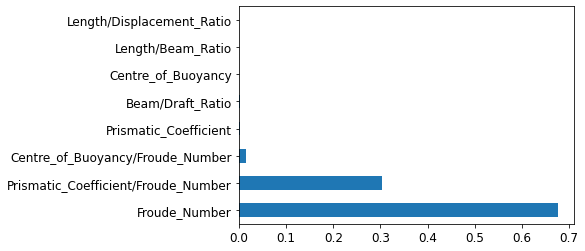

In [77]:
# plot the relative importance of each attribute for making accurate predictions
feature_importances = pd.Series(rnd_search.best_estimator_.feature_importances_, index=yacht_extra_attr.columns)
feature_importances.nlargest(8).plot(kind='barh')
plt.show()

Now, it is necessary to look at the specific errors that the system makes, try to understand why it makes them and what could fix the problem.

For example:
1. add extra features,
2. remove uninformative features,
3. clean up outliers.

# 7. Test Set Evaluation

In [78]:
import warnings
warnings.filterwarnings('ignore')

In [79]:
final_model = rnd_search.best_estimator_

X_test = strat_test_set.drop("Residuary_Resistance", axis=1)
y_test = strat_test_set["Residuary_Resistance"].copy()

# call transform(), instead of fit_transform(), to not fit the test set 
X_test_tr = yacht_pipeline.transform(X_test.values)
final_predictions = final_model.predict(X_test_tr)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse.round(4)

0.388

In [80]:
error_percentage = (abs(y_test - final_predictions) * 100 )/y_test

In [81]:
error_table = np.block([[final_predictions.round(2)], [y_test], [error_percentage.round(2)]]).T

In [82]:
pd.set_option('display.max_rows', None)
pd.DataFrame(error_table, columns=["Predicted values", "Correct values", "Error (%)"])

,Predicted values,Correct values,Error (%)
0,0.40,0.40,0.39
1,4.60,3.87,18.83
2,0.11,0.05,129.37
3,12.74,12.27,3.82
4,0.84,0.79,6.72
5,12.68,11.56,9.70
6,0.86,0.78,9.81
7,2.48,2.28,8.75
8,0.79,0.93,14.69
9,3.49,3.43,1.68


<AxesSubplot:>

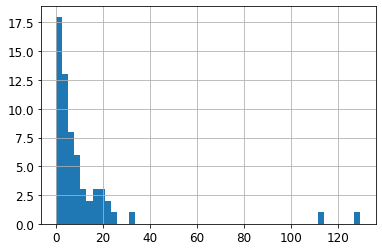

In [83]:
error_percentage.hist(bins=50)

In [84]:
# the generalization error that the model makes
print("The mean error:", error_percentage.mean().round(2), "%")

The mean error: 11.16 %


# 8. Deploy the model

1. Save the model,
2. Develop a web service that enables using of the model in practice,
3. Deploy the application on the cloud.

## Save the model

In [85]:
import pickle

# open a file and dump the model to that file
with open("model.bin", 'wb') as f_out:
    pickle.dump(final_model, f_out)
    f_out.close()